In [54]:
# Allows code to live reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Install
```sh
# Install prerequisites
pip install pyodc

```

## 2. Make an ECMWF account
- Go to ecmwf.int/, click login at the top right and click register to make a new account.
- Once logged in, go to api.ecmwf.int/v1/key/ to get your key. 
- Put it in `~/.ecmwfapirc` as directed.

In [55]:
# Load in the ECMWF token 
from pathlib import Path
import json
import requests
from IPython.display import JSON, display
from datetime import datetime as dt
from datetime import timedelta, timezone
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

with open(Path("~/.ecmwfapirc").expanduser(), "r") as f:
    api_creds = json.load(f)

print("Checking API credentials")
r = requests.get(f"https://api.ecmwf.int/v1/who-am-i?token={api_creds['key']}")
if r.status_code == 403: print("Your credentials are either wrong or need to be renewed at https://api.ecmwf.int/v1/key/")
r.raise_for_status()
JSON(r.json())

Checking API credentials


<IPython.core.display.JSON object>

In [56]:
session = requests.Session()
session.headers["Authorization"] = f"Bearer {api_creds['key']}"

In [57]:
# url = "http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/api/v1/"
url = "http://localhost:5002/api/v1/"

In [58]:
from datetime import datetime

stations = session.get(url + "stations").json()
print(f"{len(stations) = }")

len(stations) = 11


In [59]:
granules = session.get(url + "list").json()
print(f"{len(granules) = }")

len(granules) = 71


In [60]:
from collections import Counter
types = Counter(s["platform"] for s in stations)
types

Counter({'meteotracker': 10, 'acronet': 1})

In [61]:
from collections import defaultdict
by_platform = defaultdict(list)
for s in stations:
    by_platform[s["platform"]].append(s)

print("Most recently updated entry from each platform\n")
for platform, platform_stations in by_platform.items():
    print(platform)
    print(json.dumps(
        sorted(platform_stations, key = lambda s : datetime.fromisoformat(s["time_span"][1]) )[-1],
    indent = 4))

Most recently updated entry from each platform

meteotracker
{
    "name": "MeteoTracker Track",
    "description": "A MeteoTracker Track.",
    "platform": "meteotracker",
    "external_id": "6758514adf3691091821fd2c",
    "internal_id": "04d61eb7744a9d9c",
    "location": [
        8.6832416,
        44.38961995
    ],
    "time_span": [
        "2024-12-10T14:33:44.011000Z",
        "2024-12-10T15:20:45.011000Z"
    ],
    "authors": [
        {
            "name": "meteotracker"
        },
        {
            "name": "CIMA I-Change"
        }
    ],
    "mars_request": {
        "class": "rd",
        "expver": "xxxx",
        "stream": "lwda",
        "aggregation_type": "tracked",
        "platform": "meteotracker",
        "internal_id": "04d61eb7744a9d9c",
        "date": "20241210"
    }
}
acronet
{
    "name": "Monte Santa Croce",
    "description": "An Acronet station",
    "platform": "acronet",
    "external_id": "monte_santa_croce",
    "internal_id": "08fcafda1bb07325"

## Obtain a whole meteotracker track

For meteotracker tracks it is sufficient to simply use the "mars_request" as a key to the retrieve endpoint (along with format=csv) to download the data.

In [62]:
from io import BytesIO

example_station = by_platform["meteotracker"][-1]

args = {
    "format" : "csv"
}

data = session.get(url + "retrieve", params = example_station["mars_request"] | args)

df = pd.read_csv(BytesIO(data.content))
df

,class,expver,stream,project,platform,aggregation_type,source_name,external_id,internal_id,date,relative_humidity_near_surface,solar_radiation_index,air_temperature_near_surface,potential_temperature,dew_point_temperature,humidity_index,altitude,lat,lon,datetime
0,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,52,0.8,285.55,284.4,276.05,284.15,18.0,44.400153,8.932653,2024-12-10T10:49:04Z
1,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,51,0.9,285.45,284.4,275.85,283.95,19.0,44.400708,8.932082,2024-12-10T10:49:09Z
2,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,51,0.8,285.55,284.4,275.85,284.05,21.0,44.401402,8.931612,2024-12-10T10:49:14Z
3,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,51,0.8,285.55,284.4,275.75,283.95,19.0,44.402645,8.930767,2024-12-10T10:49:24Z
4,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,51,0.8,285.45,284.3,275.65,283.85,20.0,44.403185,8.930212,2024-12-10T10:49:29Z
5,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,50,0.8,285.25,284.1,275.35,283.55,18.0,44.403763,8.929665,2024-12-10T10:49:34Z
6,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,51,0.8,285.25,284.1,275.45,283.65,17.0,44.404915,8.928428,2024-12-10T10:49:44Z
7,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,51,0.8,284.95,283.9,275.35,283.35,16.0,44.407617,8.927835,2024-12-10T10:50:04Z
8,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,52,0.8,284.95,283.9,275.35,283.25,15.0,44.408320,8.928215,2024-12-10T10:50:09Z
9,rd,xxxx,lwda,I-CHANGE,meteotracker,tracked,CIMA I-Change,67581ca4df36910918fa9a73,913e065a777ce44e,20241210,51,0.7,284.85,283.8,275.35,283.25,11.0,44.409008,8.928223,2024-12-10T10:50:14Z


In [63]:
import geopandas as gpd
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326)
geo_df.explore(column = "altitude")

## Obtain Acronet data and other streams

For the meteotracker data, each track is stored in a single data file. For continuous streams of data like the acronet stations, it is stored in 5 minute granules.

In [64]:
[station["name"] for station in by_platform["acronet"]][:10] + [f"... {len(by_platform["acronet"])} in total"]

['Monte Santa Croce', '... 1 in total']

In [65]:
example_station = by_platform["acronet"][-1]
example_station

{'name': 'Monte Santa Croce',
 'description': 'An Acronet station',
 'platform': 'acronet',
 'external_id': 'monte_santa_croce',
 'internal_id': '08fcafda1bb07325',
 'location': [9.679447, 44.148647],
 'time_span': ['2024-12-10T15:20:00Z', '2024-12-10T15:25:00Z'],
 'authors': [{'name': 'acronet'}],
 'mars_request': {'class': 'rd',
  'expver': 'xxxx',
  'stream': 'lwda',
  'aggregation_type': 'chunked',
  'platform': 'acronet',
  'internal_id': '08fcafda1bb07325'}}

Giving the "mars_request" to the `list` endpoint gives the list of data granules available from the list endpoint. For the acronet data and other continuous streams, there is an additional key "time" which gives the begining of the interval in the format HHMM

In the MARS system one needs to deal with these separate `date` and `time` fields but for convenience two special arguments are added to the API: `start_time` and `end_time`, these ISO formatted fields will be used to return data granules within the defined temporal region.

* If `start_time` or `end_time` are supplied, `date` and `time` are ignored. 
* If `start_time` or `end_time` fall within the boundary of a data chunk, the whole chunk will be returned.
* If only one of `start_time` or `end_time` are supplied, the other will be determined from the data.
* If neither `start_time` nor `end_time` are supplied, `date` and `time` will be used following the typical MARS language.

The `list` endpoint is not necessary, but can be useful to retrieve the available chunks for a mars request. The arguments to `list` and `retrieve` are the same, list returns what data granules exist and `retrieve` returns the data granules concatenated together.

### All the data for an acronet station

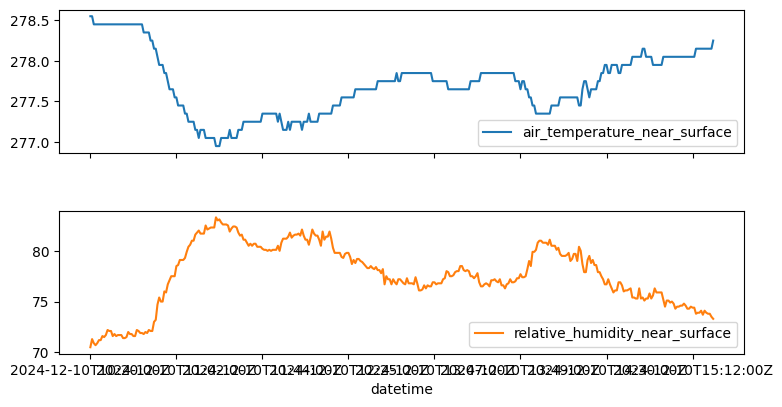

In [66]:
example_station = by_platform["acronet"][-1]

args = {
    "format" : "csv"
}

data = session.get(url + "retrieve", params = example_station["mars_request"] | args)

df = pd.read_csv(BytesIO(data.content))
df = df.set_index('datetime')
df.plot(
    y = ["air_temperature_near_surface", "relative_humidity_near_surface"],
    subplots=True, layout=(len(df.columns), 1), figsize=(8, 2 * len(df.columns)), sharex=True)
plt.tight_layout()

### Retrieve the list of data granules for a station

In [71]:
data_granules = session.get(url + "list", params = example_station["mars_request"])
sorted([(g["mars_request"]["date"], g["mars_request"]["time"]) for g in data_granules.json()])

[('20241210', '1020'),
 ('20241210', '1025'),
 ('20241210', '1030'),
 ('20241210', '1035'),
 ('20241210', '1040'),
 ('20241210', '1045'),
 ('20241210', '1050'),
 ('20241210', '1055'),
 ('20241210', '1100'),
 ('20241210', '1105'),
 ('20241210', '1110'),
 ('20241210', '1115'),
 ('20241210', '1120'),
 ('20241210', '1125'),
 ('20241210', '1130'),
 ('20241210', '1135'),
 ('20241210', '1140'),
 ('20241210', '1145'),
 ('20241210', '1150'),
 ('20241210', '1155'),
 ('20241210', '1200'),
 ('20241210', '1205'),
 ('20241210', '1210'),
 ('20241210', '1215'),
 ('20241210', '1220'),
 ('20241210', '1225'),
 ('20241210', '1230'),
 ('20241210', '1235'),
 ('20241210', '1240'),
 ('20241210', '1245'),
 ('20241210', '1250'),
 ('20241210', '1255'),
 ('20241210', '1300'),
 ('20241210', '1305'),
 ('20241210', '1310'),
 ('20241210', '1315'),
 ('20241210', '1320'),
 ('20241210', '1325'),
 ('20241210', '1330'),
 ('20241210', '1335'),
 ('20241210', '1340'),
 ('20241210', '1345'),
 ('20241210', '1350'),
 ('20241210

### Retrieve a limited set if data (both `list` and `retrieve`)

In [68]:
from datetime import datetime, timedelta, UTC
now = datetime.now(UTC)
args = {
    "start_start": (now - timedelta(hours = 2)).isoformat(),
    "end_time": (now - timedelta(hours = 1)).isoformat(),
}
print(args)

data_granules = session.get(url + "list", params = example_station["mars_request"])
sorted([g["mars_request"]["time"] for g in data_granules.json()])

{'start_start': '2024-12-10T13:28:23.852943+00:00', 'end_time': '2024-12-10T14:28:23.852943+00:00'}


['1020',
 '1025',
 '1030',
 '1035',
 '1040',
 '1045',
 '1050',
 '1055',
 '1100',
 '1105',
 '1110',
 '1115',
 '1120',
 '1125',
 '1130',
 '1135',
 '1140',
 '1145',
 '1150',
 '1155',
 '1200',
 '1205',
 '1210',
 '1215',
 '1220',
 '1225',
 '1230',
 '1235',
 '1240',
 '1245',
 '1250',
 '1255',
 '1300',
 '1305',
 '1310',
 '1315',
 '1320',
 '1325',
 '1330',
 '1335',
 '1340',
 '1345',
 '1350',
 '1355',
 '1400',
 '1405',
 '1410',
 '1415',
 '1420',
 '1425',
 '1430',
 '1435',
 '1440',
 '1445',
 '1450',
 '1455',
 '1500',
 '1505',
 '1510',
 '1515',
 '1520']

The `retrieve` endpoint simply concatenates the datafiles matched by a given mars request.

In [69]:


now = datetime.now()

args = {
    "format" : "csv"
    "start_start": (now - timedelta(hours = 3)).isoformat()
    "end_time": now.isoformat()
}

overlapping chunks will be returned in their entirety 

data = session.get(url + "retrieve", params = example_station["mars_request"] | args)

df = pd.read_csv(BytesIO(data.content))
df

SyntaxError: invalid syntax (193359339.py, line 5)

QUestions


make sure temporal extent works for stations endpoint
is 


source_id